In [26]:
# PROJECT : Semi supervised learning by adverserial learning
# CREATED : 2023-09-28
# UPDATED : 2023-10-07
# RELATED : https://paperswithcode.com/paper/adversarial-learning-for-semi-supervised


'''
DONE

EDA
Data loader



'''


'''
On going


'''

'\nOn going\n\n\n'

In [27]:
# IMPORT LIBRARY

import pandas as pd
import os
from PIL import Image

import numpy 
import cv2

In [54]:
# Radnom Setting
# https://github.com/hritam-98/MFSNet/blob/main/train.py
# https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification
# https://pub.towardsai.net/how-i-built-supervised-skin-lesion-segmentation-on-ham10000-dataset-f293c3239746
# Control randomness

import torch
import numpy as np
import random

def set_randomness(random_seed = 777, train = True):
    np.random.seed(random_seed)
    random.seed(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    # This set will delay training session
    if not train:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_randomness()

print(f'Random seed is done...')

Random seed is done...


In [55]:
# METADATA EDA

eda_df = pd.read_csv('../HAM10000/HAM10000_metadata')

In [56]:
# FILE SAMPLE
eda_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [57]:
for code in eda_df.dx.unique():
    print(code, len(eda_df[eda_df['dx'] == code]))

bkl 1099
nv 6705
df 115
mel 1113
vasc 142
bcc 514
akiec 327


In [61]:
image_path = '../HAM10000/images/'
gt_path = '../HAM10000/masks/'

rand_img_path = random.choice([i for i in os.listdir(image_path) if '.' in i])
rand_gt_path = [i for i in os.listdir(gt_path) if rand_img_path[:-4] in i][0]

print(f'IMAGE : {rand_img_path}')
print(f'IMAGE : {rand_gt_path}')

IMAGE : ISIC_0030344.jpg
IMAGE : ISIC_0030344_segmentation.png


In [51]:
# version issue -> need to update version
# cv2.imshow('image', rand_img)

        lesion_id      image_id     dx dx_type   age     sex localization  \
9943  HAM_0007199  ISIC_0030344  akiec   histo  55.0  female         face   

        dataset  
9943  rosendahl  


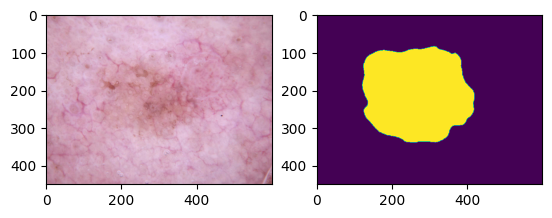

In [64]:
import matplotlib.pyplot as plt

print(eda_df[eda_df['image_id'] == str(rand_img_path[:-4])])

rand_img_gt_lst = [image_path + rand_img_path, gt_path + rand_gt_path]

figure, axes = plt.subplots(1, 2)   # (columns, rows)    
for ax, imgname in zip(axes, rand_img_gt_lst):  # Iterate over images and
        img = plt.imread(imgname)     # axes to plot one image on each.
        ax.imshow(img)                     # You can append them to an empty
                                           # list if you need them later.
plt.show()

In [35]:
#https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

In [36]:
from numpy import asarray 

# importing image into numpy : https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays
data = asarray(Image.open(rand_img_gt_lst[0]))
print(f'IMAGE CODE : {Image.fromarray(data).mode}')

# imgae slicing 255 : https://markme-inur.tistory.com/37
data = data / 255

# mean / std axis in numpy axis = https://stackoverflow.com/questions/40700501/how-to-calculate-mean-color-of-image-in-numpy-array
mean_ = np.mean(data, axis= (0, 1))
std_ = np.std(data, axis= (0, 1))

print(F'MEAN : {mean_} \nStandard Deviation : {std_}')

IMAGE CODE : RGB
MEAN : [0.76707727 0.38997913 0.4054763 ] 
Standard Deviation : [0.04298765 0.07600659 0.07768665]


In [42]:
# Dataset setting
import os
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from tqdm import tqdm

from PIL import Image

# Purpose 
# Data loader : preprocessing
# https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html
class HamDataset(Dataset):
    def __init__(self, img_dir, gt_dir, semi_sl : False):
        super().__init__()
        self.images = [img_dir + img for img in os.listdir(img_dir) if img.endswith('.jpg')]
        self.images = sorted(self.images)

        self.gts    = [gt_dir + gt for gt in os.listdir(gt_dir) if gt.endswith('.png')]
        self.gts    = sorted(self.gts)
        
        self.filter_files()
        print(f'Image list appended....')
        self.size = len(self.images)

        self.semi_sl = semi_sl
        self.transform_image()
        print(f'Normalized done...')

    def filter_files(self):
        assert len(self.images) == len(self.gts), \
            f'Loaded image size is {len(self.images)}, but ground truth size is {len(self.gts)}' \
            f'Please check the images and grouth truth.'
        image_lst, gt_lst = [], []

        for img_path, gt_path in zip(tqdm(self.images), self.gts):
            img = Image.open(img_path)
            gt  = Image.open(gt_path)
            
            if img.size == gt.size :
                image_lst.append(img_path)
                gt_lst.append(gt_path)
                del img, gt
            
        self.images = image_lst
        self.gts = gt_lst
        
        del image_lst, gt_lst

    def transform_image(self):
        if not self.semi_sl :
            self.img_transform = transforms.Compose([
                transforms.ToTensor(),
                # Image normalization
                    #this part is for total images, not for the semi SL
                    #Also need to check for the total image
                    transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])
                ])
        else:
            self.img_transform = transforms.Compose([
                transforms.ToTensor()])
            
        self.gt_transform = transforms.Compose([
            transforms.ToTensor()])
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        assert len(self.images) == len(self.gts), \
            f'Loaded image size is {len(self.images)}, but ground truth size is {len(self.gts)}' \
            f'Please check the images and grouth truth.'
        image   = self.rgb_loader(self.images[index])
        image   = self.img_transform(image)

        gt      = self.binaray_loader(self.gts[index])
        gt      = self.gt_transform(gt)
        return image, gt
        
    # Training images
    def rgb_loader(self, path):
        with open(path, 'rb') as r:
            img = Image.open(r)
            return img.convert('RGB')
    
    # Ground truth images
    def binaray_loader(self, path):
        with open(path, 'rb') as b:
            gt = Image.open(b)
            return gt.convert('L')

In [43]:
%%time 

dataset = HamDataset(img_dir=image_path, gt_dir=gt_path, semi_sl=False)

100%|██████████| 10015/10015 [00:38<00:00, 263.35it/s]

Image list appended....
Normalized done...
CPU times: total: 2.98 s
Wall time: 38.1 s


In [44]:
loader= DataLoader(
        dataset = dataset,
        batch_size = 64,
        shuffle = True
        )

In [45]:
train_features, train_labels = next(iter(loader))
train_features.size()

torch.Size([64, 3, 450, 600])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


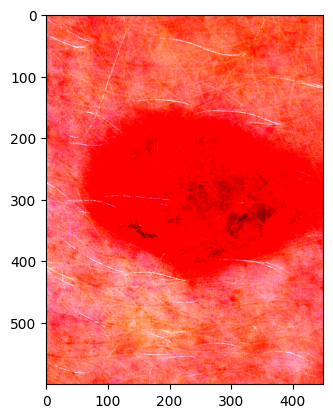

In [47]:
rand_num = 1

img = train_features[rand_num].squeeze()
plt.imshow(img.T)

### Model Creation Part

Supervised Learning with U-Net and Unsupervised learning with transformer and other papers

#### Supervised Learning

1. U-Net
2. U-Net++
3. U-Net3+

In [53]:
# Model library

import torch.nn as nn
import torch.nn.functional as F


In [ ]:
# U-NET

class DoubleConv(nn.Module):
    # UP and Down convolution is same architecture 
    # conv - Batch norm - Relu structure
    def __init__(self, in_channels, out_channels, mid_channels = None) :
        super().__init__()
        
        # Each layer contains mid_channels
        if not mid_channels: 
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
            , nn.BatchNorm2d(mid_channels)   
            , nn.ReLU(inplace=True)
            , nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)
            , nn.BatchNorm2d(out_channels)
            , nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)
    
    
class Down(nn.Module):
    # Down convolution
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2)
            ,   DoubleConv(in_channels, out_channels)
        )    

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    # Up convolution
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up_conv(x1)    
        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)        


class OutConv(nn.Module):
    def __init__(self, in